In [3]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from PIL import Image
import torch
import glob
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


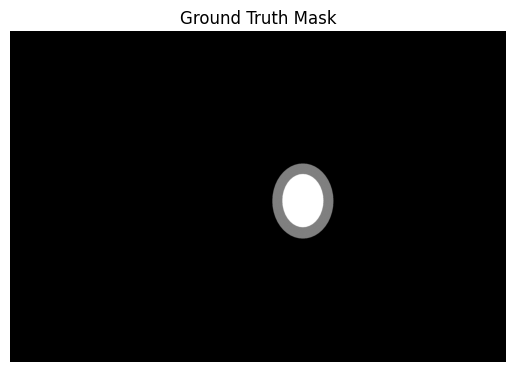

In [4]:
import scipy.io
import matplotlib.pyplot as plt

# Load the .mat file
mat = scipy.io.loadmat(r'ORIGA/ORIGA/Semi-automatic-annotations/001.mat')

# Extract the mask
mask = mat['mask']  # This is a numpy array of shape (2048, 3072)

# Visualize the mask
plt.imshow(mask, cmap='gray')
plt.title('Ground Truth Mask')
plt.axis('off')
plt.show()

In [ ]:
class ROISegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None, mask_key='mask'):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.mask_key = mask_key

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        image = Image.open(image_path).convert('RGB')
        mat = loadmat(mask_path)
        mask = mat[self.mask_key]  # 0=bg, 1=OD, 2=OC

        if mask.shape != image.size[::-1]:
            mask = Image.fromarray(mask.astype(np.uint8))
            mask = mask.resize(image.size, resample=Image.NEAREST)
            mask = np.array(mask)

        image = np.array(image).transpose(2, 0, 1) / 255.0
        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.long)  # integer labels for CrossEntropyLoss

        if self.transform:
            
            pass

        return image, mask


In [30]:
image_dir = 'ORIGA/ORIGA/roi_images'
mask_dir = 'ORIGA/ORIGA/Semi-automatic-annotations'

image_paths = sorted(glob(os.path.join(image_dir, "*.jpg")))
mask_paths = sorted(glob(os.path.join(mask_dir, "*.mat")))

# Match by basename
image_basenames = {os.path.splitext(os.path.basename(f))[0]: f for f in image_paths}
mask_basenames = {os.path.splitext(os.path.basename(f))[0]: f for f in mask_paths}
common_names = sorted(set(image_basenames) & set(mask_basenames))
paired_images = [image_basenames[name] for name in common_names]
paired_masks = [mask_basenames[name] for name in common_names]

train_imgs, test_imgs, train_masks, test_masks = train_test_split(
    paired_images, paired_masks, test_size=0.2, random_state=42)

train_dataset = ROISegmentationDataset(train_imgs, train_masks)
test_dataset  = ROISegmentationDataset(test_imgs, test_masks)
train_loader  = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader   = DataLoader(test_dataset, batch_size=4, shuffle=False)



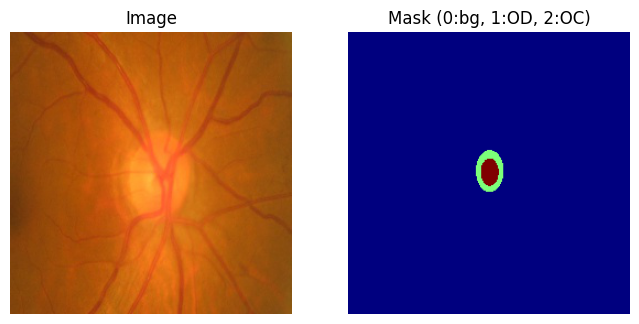

In [31]:


img, msk = train_dataset[0]
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img.permute(1,2,0))
plt.title('Image')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(msk, cmap='jet', vmin=0, vmax=2)
plt.title('Mask (0:bg, 1:OD, 2:OC)')
plt.axis('off')
plt.show()


In [32]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())
        self.pool1 = nn.MaxPool2d(2, 2)
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU())
        self.pool2 = nn.MaxPool2d(2, 2)
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU())
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU())
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())
        self.conv_last = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        b = self.bottleneck(p2)
        up2 = self.up2(b)
        cat2 = torch.cat([up2, e2], dim=1)
        d2 = self.dec2(cat2)
        up1 = self.up1(d2)
        cat1 = torch.cat([up1, e1], dim=1)
        d1 = self.dec1(cat1)
        out = self.conv_last(d1)
        return out

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3, out_channels=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train_unet(model, loader, criterion, optimizer, device, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            masks = masks.squeeze(1) if masks.ndim == 4 else masks  # Ensure [B, H, W]
            optimizer.zero_grad()
            outputs = model(images)  # (B, 3, H, W)
            loss = criterion(outputs, masks)  # masks: (B, H, W)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * images.size(0)
        avg_loss = total_loss / len(loader.dataset)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

train_unet(model, train_loader, criterion, optimizer, device, epochs=10)

Epoch 1, Loss: 0.1229
Epoch 2, Loss: 0.0763
Epoch 3, Loss: 0.0771
Epoch 4, Loss: 0.0748
Epoch 5, Loss: 0.0758
Epoch 6, Loss: 0.0747
Epoch 7, Loss: 0.0748
Epoch 8, Loss: 0.0752
Epoch 9, Loss: 0.0758
Epoch 10, Loss: 0.1163


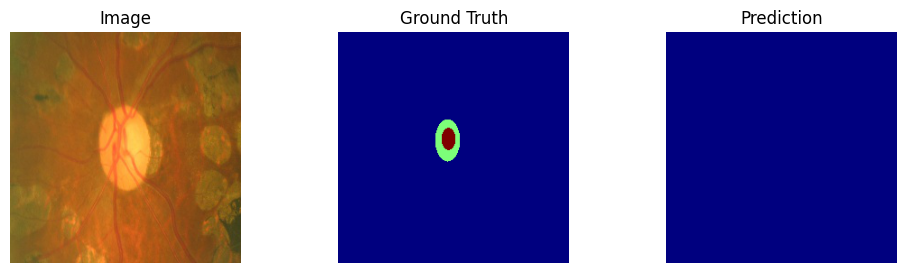

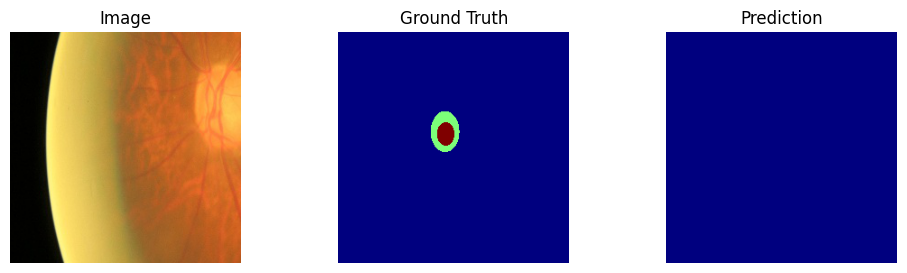

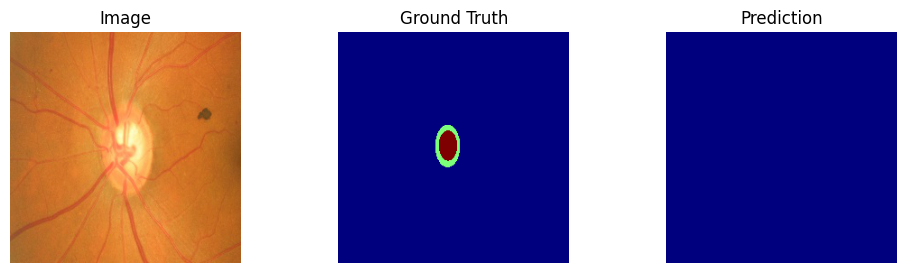

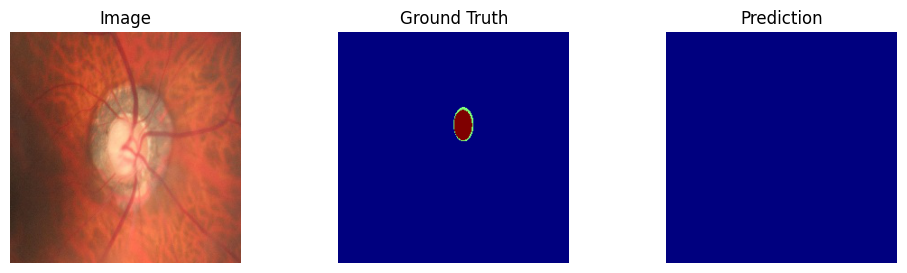

In [34]:
model.eval()
with torch.no_grad():
    images, masks = next(iter(test_loader))
    images = images.to(device)
    outputs = model(images)
    preds = outputs.argmax(1).cpu()  # (B, H, W)
    images = images.cpu()

for i in range(min(4, images.shape[0])):
    plt.figure(figsize=(12,3))
    plt.subplot(1,3,1)
    plt.imshow(images[i].permute(1,2,0))
    plt.title('Image')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(masks[i], cmap='jet', vmin=0, vmax=2)
    plt.title('Ground Truth')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(preds[i], cmap='jet', vmin=0, vmax=2)
    plt.title('Prediction')
    plt.axis('off')
    plt.show()